In [1]:
import torch
from dataset import *
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

epochs = 500
test_perc = 0.1
window_size = 200
stride = 10
batch_size = 32

x_gyro = []
x_acc = []
x_mag = []

y_delta_p = []
y_delta_q = []

imu_data_filenames = []
gt_data_filenames = []

imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu1.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu7.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu4.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/imu5.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu2.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu1.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu3.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/imu5.csv')
imu_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/imu4.csv')

gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi1.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi7.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data5/syn/vi4.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data4/syn/vi5.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi2.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data2/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi1.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi3.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data3/syn/vi5.csv')
gt_data_filenames.append('Oxford Inertial Odometry Dataset/handheld/data1/syn/vi4.csv')

for i, (cur_imu_data_filename, cur_gt_data_filename) in enumerate(zip(imu_data_filenames, gt_data_filenames)):
    cur_gyro_data, cur_acc_data, curr_mag_data, cur_pos_data, cur_ori_data = load_oxiod_dataset(cur_imu_data_filename, cur_gt_data_filename)

    [cur_x_gyro, cur_x_acc, curr_x_mag], [cur_y_delta_p, cur_y_delta_q], init_p, init_q = load_dataset_6d_quat(cur_gyro_data, cur_acc_data, curr_mag_data, cur_pos_data, cur_ori_data, window_size, stride)

    x_gyro.append(cur_x_gyro)
    x_acc.append(cur_x_acc)
    x_mag.append(curr_x_mag)
    y_delta_p.append(cur_y_delta_p)
    y_delta_q.append(cur_y_delta_q)

x_gyro = np.vstack(x_gyro)
x_acc = np.vstack(x_acc)
x_mag = np.vstack(x_mag)
y_delta_p = np.vstack(y_delta_p)
y_delta_q = np.vstack(y_delta_q)

# create tensors and move to device
x_gyro = torch.tensor(x_gyro, dtype=torch.float32)
x_acc = torch.tensor(x_acc, dtype=torch.float32)
x_mag = torch.tensor(x_mag, dtype=torch.float32)
y_delta_p = torch.tensor(y_delta_p, dtype=torch.float32)
y_delta_q = torch.tensor(y_delta_q, dtype=torch.float32)
x_input = torch.cat([x_gyro, x_acc, x_mag], dim=-1).to(device)
y_output = torch.cat([y_delta_p, y_delta_q], dim=-1).to(device)
# y_output = y_delta_p.to(device)

# split data
dataset = TensorDataset(x_input, y_output)
test_size = int(test_perc * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=False)

{"gyro":x_gyro.shape, "acc":x_acc.shape, "mag":x_mag.shape, "pos":y_delta_p.shape, "quat":y_delta_q.shape}
{'x_input':x_input.shape, 'y_input':y_output.shape}

cuda


{'x_input': torch.Size([61115, 200, 9]), 'y_input': torch.Size([61115, 7])}

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from quaturnion_torch import *

conj = torch.tensor([1, -1, -1, -1], dtype=torch.float32).to(device)

# class QuaternionMultiplicativeError(nn.Module):
    

class QuaternionMeanMultiplicativeError(nn.Module):
    def forward(self, y_true, y_pred):
        q_hat = y_true
        q = normalize(y_pred)
        # conjuguate
        q_hat = q_hat * conj
        q_prod = quaternion_multiply(q_hat, q)
        w, x, y, z = torch.unbind(q_prod, -1)
        q_abs = torch.abs(torch.concat([x,y,z], axis=-1) * 2)
        return torch.mean(q_abs)

class CustomMultiLossLayer(nn.Module):
    def __init__(self):
        super(CustomMultiLossLayer, self).__init__()
        self.log_vars = nn.Parameter(torch.zeros(2, 1), requires_grad=True)

    def forward(self, ys_true, ys_pred):
        assert ys_true.shape == ys_pred.shape
        loss = 0

        # For the 3D vector output (position), it uses mean squared error (F.mse_loss) as the loss function.
        precision_pos = torch.exp(-self.log_vars[0])
        loss += precision_pos * F.mse_loss(ys_true[:, :3], ys_pred[:, :3]) + self.log_vars[0]

        # For the quaternion output, it uses a custom quaternion error function (QuaternionMeanMultiplicativeError).
        precision_quat = torch.exp(-self.log_vars[1])
        loss += precision_quat * QuaternionMeanMultiplicativeError()(ys_true[:, 3:], ys_pred[:, 3:]) + self.log_vars[1]

        return torch.mean(loss)

class Model6DQuat(nn.Module):
    def __init__(self, enable_mag=False):
        super(Model6DQuat, self).__init__()
        self.enable_mag = enable_mag
        self.conv1 = nn.Conv1d(3, 128, kernel_size=11, padding='valid')
        self.conv2 = nn.Conv1d(128, 128, kernel_size=11, padding='valid')
        self.maxpool = nn.MaxPool1d(3)
        # model input size should be changed to 384 instead of 256 fopr mag integration
        if self.enable_mag:
            self.lstm = nn.LSTM(384, 128, bidirectional=True, batch_first=True, num_layers=2, dropout=0.25)
        else:
            self.lstm = nn.LSTM(256, 128, bidirectional=True, batch_first=True, num_layers=2, dropout=0.25)
        self.fc1 = nn.Linear(256, 3)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x1 = x[:, :, :3]
        x2 = x[:, :, 3:6]
        x3 = x[:, :, 6:9]

        x1 = x1.permute(0, 2, 1)
        x2 = x2.permute(0, 2, 1)
        x3 = x3.permute(0, 2, 1)

        convA1 = self.conv1(x1)
        convA2 = self.conv2(convA1)
        poolA = self.maxpool(convA2)

        convB1 = self.conv1(x2)
        convB2 = self.conv2(convB1)
        poolB = self.maxpool(convB2)

        convC1 = self.conv1(x3)
        convC2 = self.conv2(convC1)
        poolC = self.maxpool(convC2)
        
        if self.enable_mag:
            AB = torch.cat([poolA, poolB, poolC], dim=1).permute(0, 2, 1)
        else:
            AB = torch.cat([poolA, poolB], dim=1).permute(0, 2, 1)

        lstm_out, _ = self.lstm(AB)
        lstm_out = lstm_out[:, -1, :]
        yp_pred = self.fc1(lstm_out)
        yq_pred = self.fc2(lstm_out)
        y = torch.cat([yp_pred, yq_pred], dim=-1)
        return y
    
model = Model6DQuat().to(device)
custom_loss = CustomMultiLossLayer().to(device)

In [3]:
import matplotlib.pyplot as plt
import time
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

t = time.time()
losses = []

for epoch in range(epochs):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients to avoid accumulation
        outputs = model(inputs)
        loss = custom_loss(targets, outputs)
        losses.append(loss)
        
        loss.backward()       # Backpropagation to compute gradients
        optimizer.step()       # Update parameters based on gradients

    if epoch % (epochs/10) == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}, Time: {time.time() - t}s')
        t = time.time()

# plot losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

Epoch [0/500], Loss: 0.002216035034507513, Time: 19.183879375457764s
Epoch [50/500], Loss: 0.0026635678950697184, Time: 994.5809955596924s
Epoch [100/500], Loss: 0.0005563137237913907, Time: 1066.242696762085s
Epoch [150/500], Loss: 0.0004193594795651734, Time: 1042.9827275276184s
Epoch [200/500], Loss: 0.00036828030715696514, Time: 1037.2015171051025s
Epoch [250/500], Loss: 0.0002493995416443795, Time: 1035.8315815925598s
Epoch [300/500], Loss: 0.0002822110545821488, Time: 1036.7607858181s
Epoch [350/500], Loss: 0.00025911949342116714, Time: 1037.7528944015503s
Epoch [400/500], Loss: 0.00020926569413859397, Time: 1028.9496693611145s
Epoch [450/500], Loss: 0.00023800677445251495, Time: 1027.493723154068s


In [38]:
import numpy as np
import quaternion

def generate_trajectory_6d_quat(init_p, init_q, y_delta_p, y_delta_q):
    cur_p = np.array(init_p)
    cur_q = quaternion.from_float_array(init_q)
    pred_p = []
    pred_p.append(np.array(cur_p))

    for [delta_p, delta_q] in zip(y_delta_p, y_delta_q):
        cur_p = cur_p + np.matmul(quaternion.as_rotation_matrix(cur_q), delta_p.T).T
        cur_q = cur_q * quaternion.from_float_array(delta_q).normalized()
        pred_p.append(np.array(cur_p))

    return np.reshape(pred_p, (len(pred_p), 3))

# evaluate the model
model.eval()

losses = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        loss = custom_loss(targets, outputs)
        losses.append(loss.item())
        
print(f'avg RMSE error: {np.sqrt(np.mean(np.square(losses)))}')
torch.save(model.state_dict(), "model_6d.pt")

avg RMSE error: 0.006987323222187408


Trajectory RMSE, sequence ('Oxford Inertial Odometry Dataset/handheld/data5/syn/imu1.csv', 'Oxford Inertial Odometry Dataset/handheld/data5/syn/vi1.csv'): 7.532427417563598


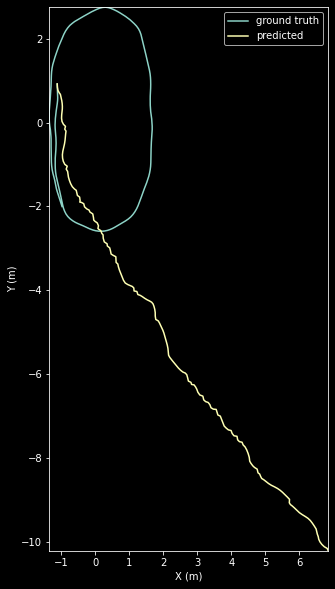

In [43]:
imu_data_fn = 'Oxford Inertial Odometry Dataset/handheld/data5/syn/imu1.csv'
gt_data_fn = 'Oxford Inertial Odometry Dataset/handheld/data5/syn/vi1.csv'
gyro_data, acc_data, mag_data, pos_data, ori_data = load_oxiod_dataset(imu_data_fn, gt_data_fn)
[x_gyro, x_acc, x_mag], [y_delta_p, y_delta_q], init_p, init_q = load_dataset_6d_quat(gyro_data, acc_data, mag_data, pos_data, ori_data, window_size, stride)



with torch.no_grad():
    input = np.concatenate([x_gyro, x_acc, x_mag], axis=-1)
    input = torch.tensor(input, dtype=torch.float32).to(device)
    yhat = model(input)

yhat_delta_p = yhat[:, :3].cpu().numpy()
yhat_delta_q = yhat[:, 3:].cpu().numpy()

gt_trajectory = generate_trajectory_6d_quat(init_p, init_q, y_delta_p, y_delta_q)
pred_trajectory = generate_trajectory_6d_quat(init_p, init_q, yhat_delta_p, yhat_delta_q)

gt_trajectory = gt_trajectory[:200]
pred_trajectory = pred_trajectory[:200]

trajectory_rmse = np.sqrt(np.mean(np.square(np.linalg.norm(pred_trajectory - gt_trajectory, axis=-1))))
print(f"Trajectory RMSE, sequence {imu_data_fn,gt_data_fn }: {trajectory_rmse}")

# fig, ax = plt.subplots(1, figsize=(5, 10), subplot_kw={'projection': '3d'})
fig, ax = plt.subplots(1, figsize=(5, 10))

ax.plot(gt_trajectory[:, 0], gt_trajectory[:, 1])#, gt_trajectory[:, 2])
ax.plot(pred_trajectory[:, 0], pred_trajectory[:, 1])#, pred_trajectory[:, 2])
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
min_x = np.minimum(np.amin(gt_trajectory[:, 0]), np.amin(pred_trajectory[:, 0]))
min_y = np.minimum(np.amin(gt_trajectory[:, 1]), np.amin(pred_trajectory[:, 1]))
max_x = np.maximum(np.amax(gt_trajectory[:, 0]), np.amax(pred_trajectory[:, 0]))
max_y = np.maximum(np.amax(gt_trajectory[:, 1]), np.amax(pred_trajectory[:, 1]))
range_x = np.absolute(max_x - min_x)
range_y = np.absolute(max_y - min_y)
max_range = np.maximum(range_x, range_y)
ax.set_xlim(min_x, min_x + range_x)
ax.set_ylim(min_y, min_y + range_y)
ax.legend(['ground truth', 'predicted'], loc='upper right')
plt.show()

In [6]:

conv1 = nn.Conv1d(3, 128, kernel_size=11, padding='valid')
conv2 = nn.Conv1d(128, 128, kernel_size=11, padding='valid')
maxpool = nn.MaxPool1d(3)
lstm = nn.LSTM(256, 128, bidirectional=True, batch_first=True, num_layers=2, dropout=0.25)
fc1 = nn.Linear(256, 3)
fc2 = nn.Linear(256, 4)
# pool of size=3, stride=2
x1 = torch.randn(32, 200, 3)
x2 = torch.randn(32, 200, 3)

h0 = torch.zeros(2, x1.size(0), 128)
c0 = torch.zeros(2, x1.size(0), 128)

x1 = x1.permute(0, 2, 1)
x2 = x2.permute(0, 2, 1)
convA1 = conv1(x1)
convA2 = conv2(convA1)
poolA = maxpool(convA2)
convB1 = conv1(x2)
convB2 = conv2(convB1)
poolB = maxpool(convB2)
AB = torch.cat([poolA, poolB], dim=1).permute(0, 2, 1)
lstm_out, _ = lstm(AB)
lstm_out = lstm_out[:, -1, :]
y1_pred = fc1(lstm_out)
# y2_pred = fc2(lstm_out)

# print(h_n.shape, c_n.shape)
print('input')
print(x1.permute(0, 2, 1).shape)
print(x1.shape)
print('conv')
print(convA1.shape)
print(convA2.shape)
print('pool')
print(poolA.shape)
print(AB.permute(0,2,1).shape)
print(AB.shape)
print('lstm')
print(lstm_out.shape)
print('dense')
print(y1_pred.shape)

input
torch.Size([32, 200, 3])
torch.Size([32, 3, 200])
conv
torch.Size([32, 128, 190])
torch.Size([32, 128, 180])
pool
torch.Size([32, 128, 60])
torch.Size([32, 256, 60])
torch.Size([32, 60, 256])
lstm
torch.Size([32, 256])
dense
torch.Size([32, 3])


In [7]:
from keras.layers import Bidirectional, LSTM, Dropout, Dense, Input, Layer, Conv1D, MaxPooling1D, concatenate
from keras import backend as K

x1 = np.random.rand(32, 200, 3)
x2 = np.random.rand(32, 200, 3)
convA1 = Conv1D(128, 11)(x1)
convA2 = Conv1D(128, 11)(convA1)
poolA = MaxPooling1D(3)(convA2)
convB1 = Conv1D(128, 11)(x2)
convB2 = Conv1D(128, 11)(convB1)
poolB = MaxPooling1D(3)(convB2)
AB = concatenate([poolA, poolB])
lstm1 = Bidirectional(LSTM(128, return_sequences=True))(AB)
drop1 = Dropout(0.25)(lstm1)
lstm2 = Bidirectional(LSTM(128))(drop1)
drop2 = Dropout(0.25)(lstm2)    
y1_pred = Dense(3)(drop2)
y2_pred = Dense(4)(drop2)

print(x1.shape)
print('double conv')
print(convA1.shape)
print(convA2.shape)
print('pooling')
print(poolA.shape)
print(AB.shape)
print('lstm1')
print(lstm1.shape)
print('drop')
print(drop1.shape)
print('lstm2')
print(lstm2.shape)
print('drop')
print(drop2.shape)
print('linear')
print(y1_pred.shape)




(32, 200, 3)
double conv
(32, 190, 128)
(32, 180, 128)
pooling
(32, 60, 128)
(32, 60, 256)
lstm1
(32, 60, 256)
drop
(32, 60, 256)
lstm2
(32, 256)
drop
(32, 256)
linear
(32, 3)
